<a href="https://colab.research.google.com/github/sogand73/OCT-Classification/blob/main/representative_dictionary_learning_for_OCT(Macular_Dataset_Heidelberg).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from PIL import Image
import cv2
import shutil
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import MiniBatchDictionaryLearning

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.0/705.0 kB 9.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Data preparing for Dictionary Learning

In [3]:
!sudo apt-get install unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [4]:
# Dataset collected from Macular Dataset Heidelberg --------> 600 train (100 validation), 200 test for each class
!unrar x '/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/Dataset.rar'


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/Dataset.rar

Creating    Dataset                                                   OK
Creating    Dataset/Test                                              OK
Creating    Dataset/Test/AMD                                          OK
Extracting  Dataset/Test/AMD/1.TIFF                                        0%  OK 
Extracting  Dataset/Test/AMD/100.TIFF                                      0%  OK 
Extracting  Dataset/Test/AMD/1000.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1018.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1021.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1022.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1026.TIFF                 

In [ ]:
# @title Selection of some images as the dataset for dictionary learning (open and store)

In [5]:
shutil.rmtree('/content/oct_my_dictl_dataset')

FileNotFoundError: [Errno 2] No such file or directory: '/content/oct_my_dictl_dataset'

In [6]:
!mkdir '/content/oct_my_dictl_dataset'


In [7]:
#classes = ['NORMAL', 'DME', 'DRUSEN', 'CNV']
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  dictl_subfolder = os.path.join('/content/oct_my_dictl_dataset/',subfolder)

  os.makedirs(dictl_subfolder, exist_ok=True)

In [12]:
# Define source and destination directories
#dataset_folder = '/content/OCT2017 /train/'  # Replace with your source folder path
dataset_folder = '/content/Dataset/Train/'

destination_folder = '/content/oct_my_dictl_dataset/'  # Replace with your destination folder path
images =[]
for subfolder in ['Normal', 'DME', 'AMD']:
  # List files in the source folder
  source_folder = os.path.join(dataset_folder, subfolder) + '/'
  files_to_copy = os.listdir(source_folder)

  # Copy each image file from the source folder to the destination folder
  for file_name in files_to_copy[:20]:
    if file_name.endswith('.TIFF'):  # Specify the image file formats
          source_path = os.path.join(source_folder, file_name)
          destination_path = os.path.join(destination_folder, subfolder) + '/'
          shutil.copy(source_path, destination_path)
          img = Image.open(os.path.join(destination_path, file_name)) # This returns an image object
          #print(img.mode)
          #img = img.convert('RGB')
          img = np.asarray(img) # convert it to ndarray
          img = cv2.resize(img, (512, 512))
          images.append(img)
#return np.array(images)
          #print(f"Copied: {file_name}")






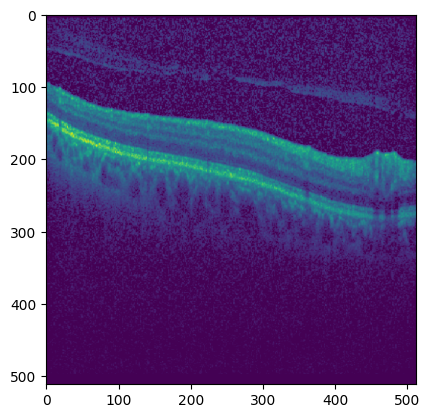

In [13]:
plt.imshow(images[1])

In [ ]:
#@title dictionary Learning Processs

In [14]:
# Load dictionary learning images
image_data = np.asarray(images)
n_images, height, width = image_data.shape

In [15]:
# Flatten the image data
X = image_data.reshape((n_images, height * width))

# Explicitly cast the array to float before division
X = X.astype(float)

# Rescale pixel values to the range [0, 1] for MiniBatchDictionaryLearning
X /= 255.0


# CLASSES: 'NORMAL', 'DME', 'AMD'
#X_NORMAL, X_DME, X_AMD = X[:10], X[10:20], X[20:30]
X_NORMAL, X_DME, X_AMD = X[:20], X[20:40], X[40:60]

In [ ]:
# Create a dictionary learning model for all data classes
n_components = 100  # Number of atoms in the dictionary
alpha = 1.0  # Sparsity controlling parameter
batch_size = 5  # Number of samples per mini-batch
n_iter = 100  # Number of iterations

dl_model = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)


# Fit the model to the flattened NORMAL image data
dl_model.fit(X)
ATOMS = dl_model.components_
X_tr = dl_model.transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


0.44733333333333336
3.2991355074941395e-12


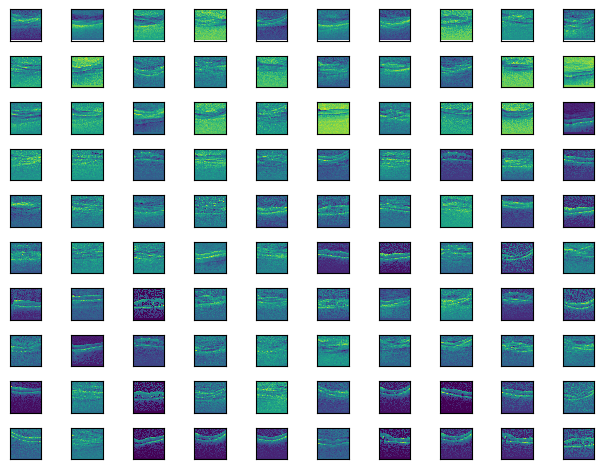

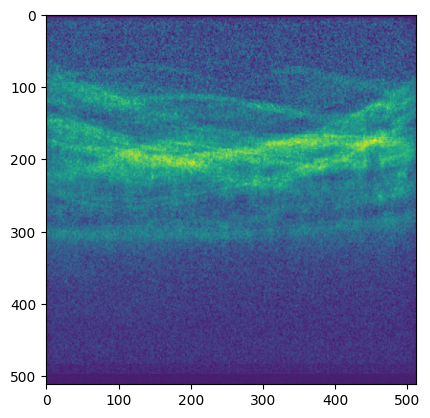

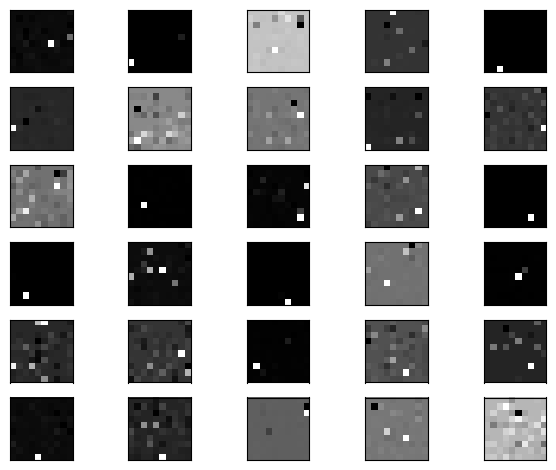

In [ ]:
#All data classes

#Feature extraction percent
print(np.mean(X_tr == 0))
X_hat = X_tr @ dl_model.components_
print(np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[0].reshape((height, width))*255)

#################################

# Visualize transformed images
representatives = X_tr
fig, axes = plt.subplots(nrows=6, ncols=5)
axes = axes.flatten()

for i in range(X_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, cmap = 'gray', interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


In [16]:
# Create a dictionary learning model for NORMAL data
n_components = 100  # Number of atoms in the dictionary
alpha = 0.8  # Sparsity controlling parameter
batch_size = 3  # Number of samples per mini-batch
n_iter = 100  # Number of iterations

dl_model_NORMAL = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)

# #Normalized data
# X_NORMAL -= np.mean(X_NORMAL, axis=0)
# X_NORMAL /= np.std(X_NORMAL, axis=0)

# Fit the model to the flattened NORMAL image data
dl_model_NORMAL.fit(X_NORMAL)
ATOMS_NORMAL = dl_model_NORMAL.components_
X_NORMAL_tr = dl_model_NORMAL.transform(X_NORMAL)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


In [19]:
# Create a dictionary learning model for DME data
n_components = 100  # Number of atoms in the dictionary
alpha = 0.8  # Sparsity controlling parameter
batch_size = 3  # Number of samples per mini-batch
n_iter = 100  # Number of iterations

dl_model_DME = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)

#Normalized data
# X_DME -= np.mean(X_DME, axis=0)
# X_DME /= np.std(X_DME, axis=0)

# Fit the model to the flattened DME image data
dl_model_DME.fit(X_DME)
ATOMS_DME = dl_model_DME.components_
X_DME_tr = dl_model_DME.transform(X_DME)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


In [21]:
# Create a dictionary learning model for AMD data
n_components = 100  # Number of atoms in the dictionary
alpha = 0.8  # Sparsity controlling parameter
batch_size = 3  # Number of samples per mini-batch
n_iter = 100  # Number of iterations

dl_model_AMD = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)

#Normalized data
# X_AMD -= np.mean(X_AMD, axis=0)
# X_AMD /= np.std(X_AMD, axis=0)

# Fit the model to the flattened AMD image data
dl_model_AMD.fit(X_AMD)
ATOMS_AMD = dl_model_AMD.components_
X_AMD_tr = dl_model_AMD.transform(X_AMD)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


In [23]:
!mkdir '/content/atoms'


In [24]:
classes = ['NORMAL', 'DME', 'AMD']
for subfolder in classes:
  dictl_subfolder = os.path.join('/content/atoms/',subfolder)

  os.makedirs(dictl_subfolder, exist_ok=True)

In [25]:

#atoms save as an image

for atom in [[ATOMS_NORMAL,'NORMAL'], [ATOMS_DME,'DME'], [ATOMS_AMD,'AMD']]:
  for i in range(n_components):
    atoms_save = atom[0][i].reshape((512, 512))*255
    atoms_save = atoms_save.astype(np.uint8)
    destination_atom_folder = os.path.join('/content/atoms/', atom[1], str(i)+'.jpeg')
    cv2.imwrite(destination_atom_folder, atoms_save)

0.493
4.3432170864929586e-12


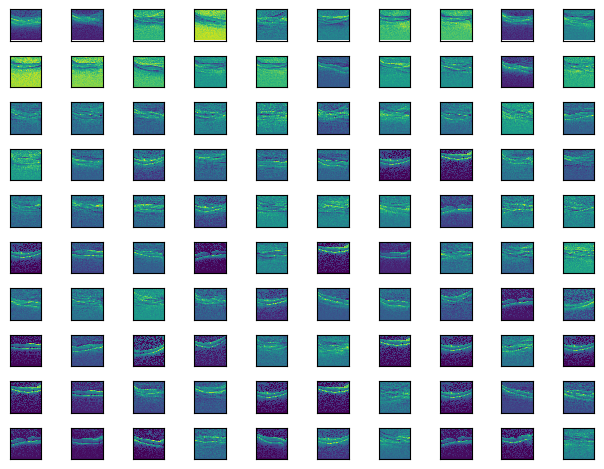

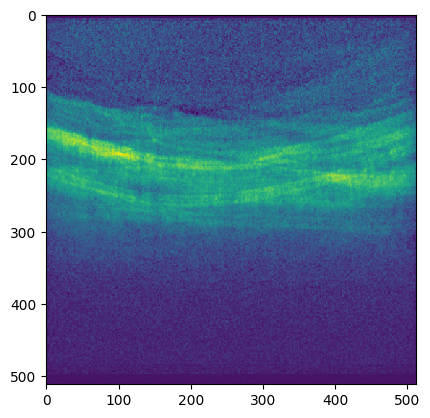

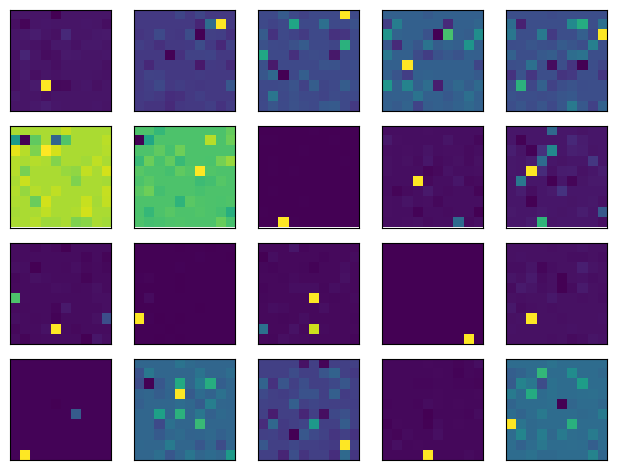

In [39]:
#NORMAL data

#Feature extraction percent
print(np.mean(X_NORMAL_tr == 0))
X_NORMAL_hat = X_NORMAL_tr @ dl_model_NORMAL.components_
print(np.mean(np.sum((X_NORMAL_hat - X_NORMAL) ** 2, axis=1) / np.sum(X_NORMAL ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS_NORMAL
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[0].reshape((height, width))*255, interpolation='nearest')

#################################

# Visualize transformed images
representatives = X_NORMAL_tr
fig, axes = plt.subplots(nrows=4, ncols=5)
axes = axes.flatten()

for i in range(X_NORMAL_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


0.5065
2.2009847042107844e-12


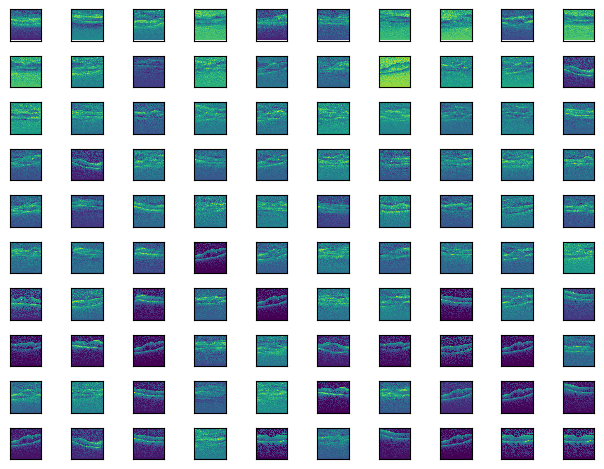

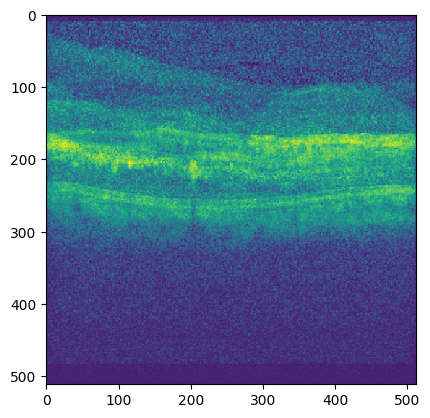

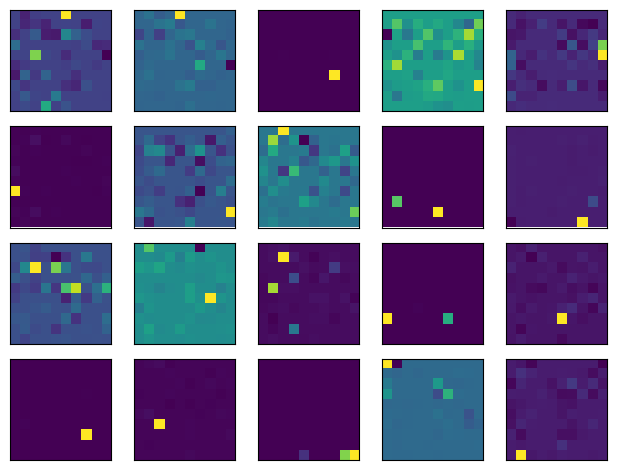

In [20]:
#DME data

#Feature extraction percent
print(np.mean(X_DME_tr == 0))
X_DME_hat = X_DME_tr @ dl_model_DME.components_
print(np.mean(np.sum((X_DME_hat - X_DME) ** 2, axis=1) / np.sum(X_DME ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS_DME
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[0].reshape((height, width))*255, interpolation='nearest')

#################################

# Visualize transformed images
representatives = X_DME_tr
fig, axes = plt.subplots(nrows=4, ncols=5)
axes = axes.flatten()

for i in range(X_DME_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


0.4885
3.3761379587914074e-12


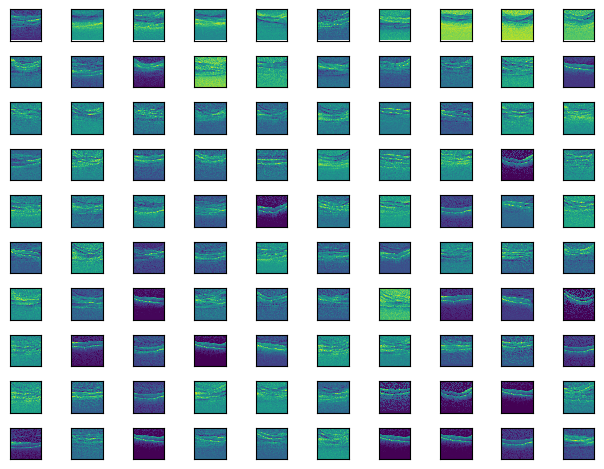

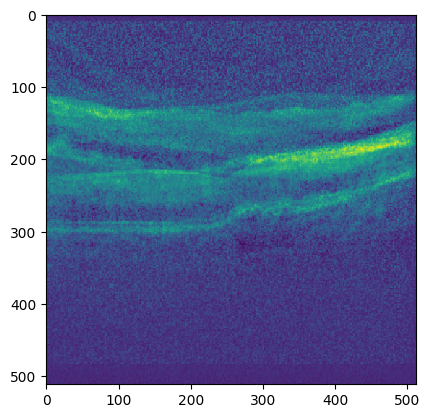

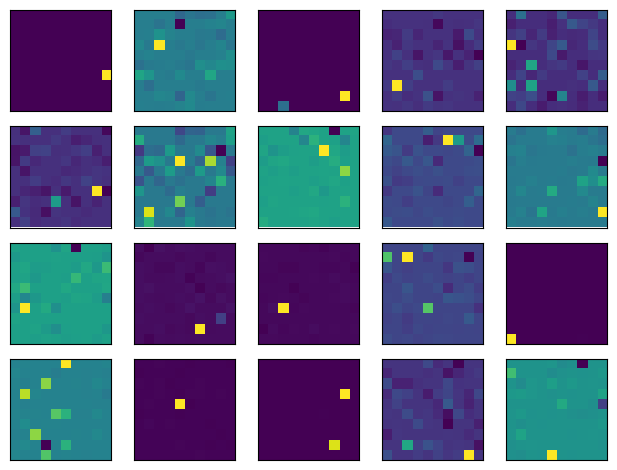

In [22]:
#AMD data

#Feature extraction percent
print(np.mean(X_AMD_tr == 0))
X_AMD_hat = X_AMD_tr @ dl_model_AMD.components_
print(np.mean(np.sum((X_AMD_hat - X_AMD) ** 2, axis=1) / np.sum(X_AMD ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS_AMD
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[0].reshape((height, width))*255, interpolation='nearest')

#################################

# Visualize transformed images
representatives = X_AMD_tr
fig, axes = plt.subplots(nrows=4, ncols=5)
axes = axes.flatten()

for i in range(X_AMD_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


In [ ]:
#@title Classification using YOLOv8

In [ ]:
!pip install ultralytics

In [26]:
shutil.rmtree('/content/oct_my_dataset')

FileNotFoundError: [Errno 2] No such file or directory: '/content/oct_my_dataset'

In [27]:
import os
!mkdir '/content/oct_my_dataset'
!mkdir '/content/oct_my_dataset/Train'
!mkdir '/content/oct_my_dataset/Test'
!mkdir '/content/oct_my_dataset/Val'


In [28]:
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  train_subfolder = os.path.join('/content/oct_my_dataset/Train/',subfolder)
  test_subfolder = os.path.join('/content/oct_my_dataset/Test/',subfolder)
  val_subfolder = os.path.join('/content/oct_my_dataset/Val/',subfolder)
  os.makedirs(train_subfolder, exist_ok=True)
  os.makedirs(test_subfolder, exist_ok=True)
  os.makedirs(val_subfolder, exist_ok=True)

In [29]:
import shutil


# Define source and destination directories
dataset_folder = '/content/Dataset'  # Replace with your source folder path

destination_folder = '/content/oct_my_dataset/'  # Replace with your destination folder path

#for folder in [['Train/',500], ['Test/',200], ['val/',100]]:
for folder in [['Train/',600], ['Test/',200]]:
  for subfolder in ['Normal', 'DME', 'AMD']:
    # List files in the source folder
    source_folder = os.path.join(dataset_folder, folder[0], subfolder) + '/'
    files_to_copy = os.listdir(source_folder)

    # Copy each image file from the source folder to the destination folder
    for file_name in files_to_copy[:folder[1]]:
        if file_name.endswith('.TIFF'):  # Specify the image file formats
            source_path = os.path.join(source_folder, file_name)
            destination_path = os.path.join(destination_folder, folder[0], subfolder) + '/'
            shutil.copy(source_path, destination_path)
            #print(f"Copied: {file_name}")


In [30]:
#Separate and store Val data from train data
# Define source and destination directories
dataset_folder = '/content/oct_my_dataset/Train/'  # Replace with your source folder path

destination_folder = '/content/oct_my_dataset/Val/'  # Replace with your destination folder path



for subfolder in ['Normal', 'DME', 'AMD']:
  # List files in the source folder
  source_folder = os.path.join(dataset_folder, subfolder) + '/'
  files_to_copy = os.listdir(source_folder)

  # Copy each image file from the source folder to the destination folder
  for num in range(500,600):
    file_name = files_to_copy[num]
    if file_name.endswith('.TIFF'):  # Specify the image file formats
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, subfolder) + '/'
        shutil.copy(source_path, destination_path)
        #print(f"Copied: {file_name}")

In [31]:
shutil.rmtree('/content/oct_my_trdataset')

FileNotFoundError: [Errno 2] No such file or directory: '/content/oct_my_trdataset'

In [32]:
import os
!mkdir '/content/oct_my_trdataset'
!mkdir '/content/oct_my_trdataset/Train'
!mkdir '/content/oct_my_trdataset/Test'
!mkdir '/content/oct_my_trdataset/Val'

In [33]:
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  train_subfolder = os.path.join('/content/oct_my_trdataset/Train/',subfolder)
  test_subfolder = os.path.join('/content/oct_my_trdataset/Test/',subfolder)
  val_subfolder = os.path.join('/content/oct_my_trdataset/Val/',subfolder)
  os.makedirs(train_subfolder, exist_ok=True)
  os.makedirs(test_subfolder, exist_ok=True)
  os.makedirs(val_subfolder, exist_ok=True)

In [35]:
import shutil


# Define source and destination directories
#dataset_folder = '/content/drive/MyDrive/oct_classification/oct_my_dataset'
dataset_folder = '/content/oct_my_dataset'  # Replace with your source folder path

destination_folder = '/content/oct_my_trdataset/'  # Replace with your destination folder path

for folder in [['Train/',500], ['Test/',200], ['Val/',100]]:
  for subfolder in ['Normal', 'DME', 'AMD']:
    # List files in the source folder
    source_folder = os.path.join(dataset_folder, folder[0], subfolder) + '/'
    files_to_copy = os.listdir(source_folder)

    # Copy each image file from the source folder to the destination folder
    for file_name in files_to_copy[:folder[1]]:
        if file_name.endswith('.TIFF'):  # Specify the image file formats
            source_path = os.path.join(source_folder, file_name)
            destination_path = os.path.join(destination_folder, folder[0], subfolder) + '/'
            #shutil.copy(source_path, destination_path)
            img = Image.open(source_path) # This returns an image object
            #print(img.mode)
            #img = img.convert('RGB')
            img = np.asarray(img) # convert it to ndarray
            img = cv2.resize(img, (512, 512))
            img = img.reshape((1, 512 * 512))
            img = img.astype(float)
            img /= 255.0



            if subfolder == 'Normal':
              img_tr = dl_model_NORMAL.transform(img)
            elif subfolder == 'DME':
              img_tr = dl_model_DME.transform(img)
            elif subfolder == 'AMD':
              img_tr = dl_model_AMD.transform(img)

            # # #Normalized data
            # img_tr -= np.mean(img_tr, axis=0)
            # img_tr /= np.std(img_tr, axis=0)

            img_tr2d = img_tr.reshape((10, 10))*255
            img_tr2d = img_tr2d.astype(np.uint8)



            # Save the image to the specified directory
            save_destination = os.path.join(destination_path, file_name)
            #image_to_save.save(save_destination)
            cv2.imwrite(save_destination, img_tr2d)


            #images.append(img_tr2d)
            #print(f"Copied: {file_name}")


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the di

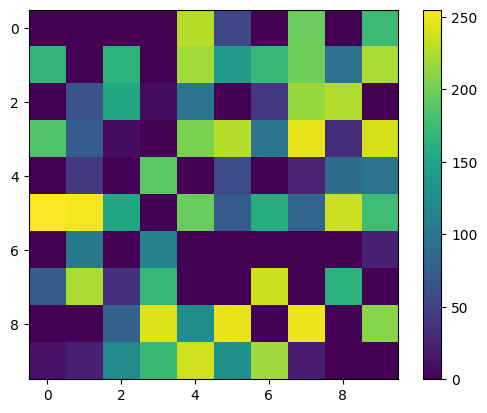

In [70]:
plt.imshow(img_tr2d.reshape((10, 10)), interpolation='nearest')
plt.colorbar()

TypeError: Image data of dtype object cannot be converted to float

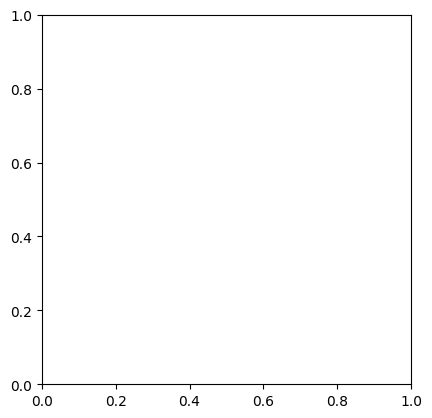

In [73]:
c = cv2.imread(save_destination)
plt.imshow(c, interpolation='nearest')
plt.colorbar()

In [38]:
from ultralytics import YOLO

# Load a model

#model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)
#model = YOLO('/content/runs/classify/train2/weights/best.pt') #Load the initial weights, gained from the former model training on this data (previous line)

model = YOLO('yolov8n-cls.yaml')  # build a new model from YAML
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8n-cls.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights

# Train the model
results = model.train(data='/content/oct_my_trdataset', epochs=100, imgsz=10, batch=64)

YOLOv8n-cls summary: 99 layers, 2719288 parameters, 2719288 gradients, 4.4 GFLOPs


100%|██████████| 5.30M/5.30M [00:00<00:00, 90.9MB/s]


YOLOv8n-cls summary: 99 layers, 2719288 parameters, 2719288 gradients, 4.4 GFLOPs
Transferred 158/158 items from pretrained weights
Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.yaml, data=/content/oct_my_trdataset, epochs=100, time=None, patience=50, batch=64, imgsz=10, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

train: Scanning /content/oct_my_trdataset/train... 1500 images, 0 corrupt: 100%|██████████| 1500/1500 [00:00<00:00, 2481.30it/s]

train: New cache created: /content/oct_my_trdataset/train.cache



val: Scanning /content/oct_my_trdataset/val... 300 images, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 2367.26it/s]

val: New cache created: /content/oct_my_trdataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 32 train, 32 val
Using 0 dataloader workers
Logging results to runs/classify/train
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100         0G      1.371         64         32:  17%|█▋        | 4/24 [00:01<00:06,  3.06it/s]

      1/100         0G      1.337         64         32:  33%|███▎      | 8/24 [00:02<00:04,  3.67it/s]
100%|██████████| 755k/755k [00:00<00:00, 29.2MB/s]
      1/100         0G      1.365         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


                   all      0.317          1

      Epoch    GPU_mem       loss  Instances       Size


      2/100         0G      1.272         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]

                   all      0.407          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100         0G      1.214         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.93it/s]

                   all       0.46          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100         0G      1.168         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]

                   all      0.533          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100         0G       1.13         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.81it/s]

                   all       0.55          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100         0G      1.112         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]

                   all       0.56          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100         0G      1.063         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.86it/s]

                   all       0.59          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100         0G      1.025         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s]

                   all      0.697          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100         0G     0.9524         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all      0.703          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100         0G     0.9313         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s]

                   all      0.727          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100         0G     0.8731         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.87it/s]

                   all      0.767          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100         0G      0.854         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100         0G     0.8561         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.67it/s]

                   all      0.787          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100         0G     0.8162         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s]

                   all       0.81          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100         0G     0.7843         28         32: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.63it/s]

                   all      0.837          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100         0G     0.7576         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100         0G     0.7955         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.31it/s]

                   all       0.87          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100         0G      0.749         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all      0.873          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100         0G     0.7581         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.77it/s]

                   all       0.89          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100         0G     0.7423         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.39it/s]

                   all      0.877          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100         0G     0.7451         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.21it/s]


                   all      0.873          1

      Epoch    GPU_mem       loss  Instances       Size


     22/100         0G     0.6798         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s]

                   all      0.907          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100         0G     0.6822         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]

                   all      0.903          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100         0G     0.7125         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s]

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100         0G     0.7009         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.57it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100         0G     0.6873         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100         0G     0.6768         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.93it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100         0G     0.6806         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100         0G     0.6428         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.50it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100         0G     0.6154         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100         0G     0.6354         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.61it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100         0G     0.6132         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100         0G     0.6197         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.85it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100         0G     0.6127         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.60it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100         0G     0.5945         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.89it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100         0G     0.5915         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.77it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100         0G     0.5994         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.48it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100         0G     0.5686         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100         0G     0.5583         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.60it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100         0G     0.5684         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100         0G     0.6056         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100         0G     0.5711         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.93it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100         0G     0.5436         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.42it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100         0G     0.5047         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.44it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100         0G     0.5656         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.73it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100         0G     0.5622         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.65it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100         0G      0.563         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.44it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100         0G     0.5452         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.33it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100         0G     0.5301         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.51it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100         0G     0.5611         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100         0G     0.5574         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.51it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100         0G      0.511         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.79it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100         0G      0.564         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.85it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100         0G     0.5203         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100         0G     0.5199         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.67it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100         0G     0.5121         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.48it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100         0G      0.506         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100         0G     0.4982         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.38it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100         0G     0.5246         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     60/100         0G     0.5002         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.52it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


     61/100         0G     0.4527         28         32: 100%|██████████| 24/24 [00:08<00:00,  3.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.16it/s]


                   all       0.97          1

      Epoch    GPU_mem       loss  Instances       Size


     62/100         0G     0.4832         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.31it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


     63/100         0G     0.5056         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.57it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


     64/100         0G     0.4606         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.78it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     65/100         0G     0.4809         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.41it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     66/100         0G     0.4961         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.84it/s]


                   all      0.973          1

      Epoch    GPU_mem       loss  Instances       Size


     67/100         0G     0.4785         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.81it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


     68/100         0G     0.4752         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.74it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     69/100         0G     0.4663         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     70/100         0G     0.4662         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.38it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     71/100         0G     0.4578         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]

                   all      0.973          1

      Epoch    GPU_mem       loss  Instances       Size



     72/100         0G     0.4533         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.23it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     73/100         0G     0.4325         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100         0G      0.494         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.23it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     75/100         0G     0.4619         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     76/100         0G     0.4361         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.08it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     77/100         0G     0.4339         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


     78/100         0G     0.4521         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.69it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     79/100         0G       0.44         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     80/100         0G     0.4578         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.59it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     81/100         0G     0.4502         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     82/100         0G     0.4494         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.60it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     83/100         0G     0.4389         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     84/100         0G     0.4365         28         32: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


                   all       0.98          1

      Epoch    GPU_mem       loss  Instances       Size


     85/100         0G     0.4276         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.85it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     86/100         0G     0.4389         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.69it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     87/100         0G     0.4405         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     88/100         0G     0.4294         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.74it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     89/100         0G     0.4492         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.76it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     90/100         0G     0.4458         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.36it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     91/100         0G     0.4349         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     92/100         0G     0.4028         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.98it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     93/100         0G     0.4598         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     94/100         0G     0.3959         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.31it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     95/100         0G     0.4306         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.29it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     96/100         0G     0.4386         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.79it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     97/100         0G     0.4143         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.79it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     98/100         0G     0.4193         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.06it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     99/100         0G     0.4048         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.39it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


    100/100         0G     0.4313         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.82it/s]

                   all      0.983          1



100 epochs completed in 0.186 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 73 layers, 1438723 parameters, 0 gradients, 3.3 GFLOPs
train: /content/oct_my_trdataset/train... found 1500 images in 3 classes ✅ 
val: /content/oct_my_trdataset/val... found 300 images in 3 classes ✅ 
test: /content/oct_my_trdataset/test... found 600 images in 3 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


                   all      0.987          1
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


In [55]:
# Validate the modelblob:https://colab.research.google.com/f8428635-acf6-400f-b52f-379198002792
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy

Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
train: /content/oct_my_trdataset/train... found 1500 images in 3 classes ✅ 
val: /content/oct_my_trdataset/val... found 300 images in 3 classes ✅ 
test: /content/oct_my_trdataset/test... found 602 images in 4 classes: ERROR ❌️ requires 3 classes, not 4


val: Scanning /content/oct_my_trdataset/val... 300 images, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


                   all      0.987          1
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


0.9866666793823242

In [ ]:
# @title Predict using the model



In [40]:
#test_score = model.predict(source='/content/oct_my_trdataset/test/Normal')
#0:AMD 1:DME 2:Normal
label_predict = []
label_conf = []
label_true = []

test_path = '/content/oct_my_trdataset/test/'

for subfolder in ['Normal', 'DME', 'AMD']:
  test_img_dir = os.path.join(test_path, subfolder)
  test_img = model(test_img_dir)

  for num in range(200):
    label_true.append(subfolder)
    label_predict.append(test_img[num].names[test_img[num].probs.top1])
    label_conf.append(test_img[0].probs.top1conf)

print(label_true)
print(label_predict)
print(label_conf)


image 1/200 /content/oct_my_trdataset/test/Normal/1.TIFF: 32x32 Normal 0.99, AMD 0.01, DME 0.00, 14.8ms
image 2/200 /content/oct_my_trdataset/test/Normal/100.TIFF: 32x32 Normal 0.99, AMD 0.01, DME 0.00, 5.2ms
image 3/200 /content/oct_my_trdataset/test/Normal/1001.TIFF: 32x32 Normal 0.99, DME 0.01, AMD 0.00, 12.1ms
image 4/200 /content/oct_my_trdataset/test/Normal/1013.TIFF: 32x32 Normal 0.99, AMD 0.01, DME 0.01, 11.3ms
image 5/200 /content/oct_my_trdataset/test/Normal/1019.TIFF: 32x32 Normal 1.00, AMD 0.00, DME 0.00, 12.6ms
image 6/200 /content/oct_my_trdataset/test/Normal/1020.TIFF: 32x32 Normal 1.00, DME 0.00, AMD 0.00, 13.2ms
image 7/200 /content/oct_my_trdataset/test/Normal/1024.TIFF: 32x32 Normal 1.00, DME 0.00, AMD 0.00, 11.1ms
image 8/200 /content/oct_my_trdataset/test/Normal/103.TIFF: 32x32 Normal 0.72, AMD 0.15, DME 0.13, 10.5ms
image 9/200 /content/oct_my_trdataset/test/Normal/1032.TIFF: 32x32 Normal 0.99, AMD 0.01, DME 0.00, 17.3ms
image 10/200 /content/oct_my_trdataset/tes

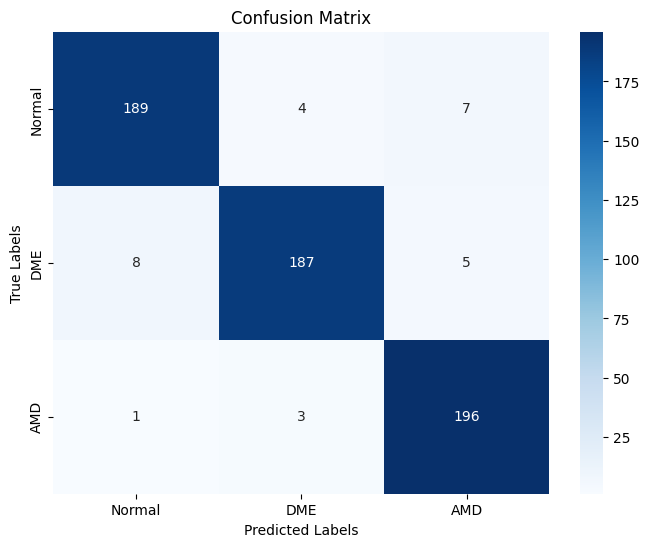

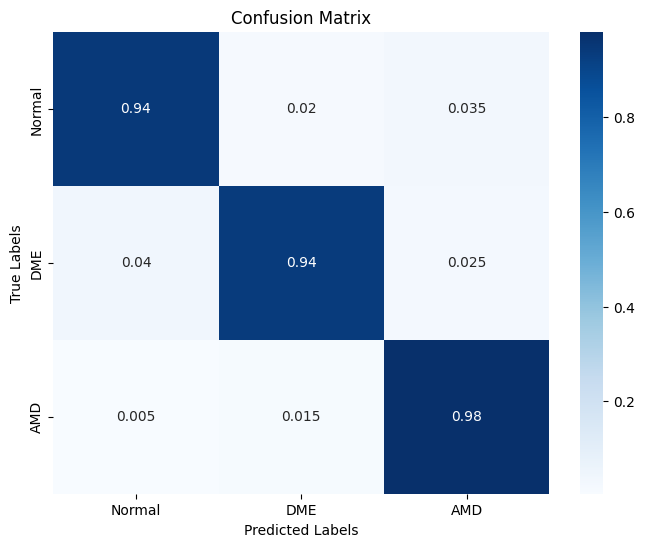

True

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(label_true, label_predict, labels=['Normal', 'DME', 'AMD'])
conf_matrix_norm = confusion_matrix(label_true, label_predict, labels=['Normal', 'DME', 'AMD'], normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'DME', 'AMD'], yticklabels=['Normal', 'DME', 'AMD'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Convert the heatmap to an image
heatmap_image = np.array(heatmap.get_figure().canvas.renderer.buffer_rgba())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap_norm = sns.heatmap(conf_matrix_norm, annot=True, cmap='Blues', xticklabels=['Normal', 'DME', 'AMD'], yticklabels=['Normal', 'DME', 'AMD'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Convert the heatmap to an image
heatmap_norm_image = np.array(heatmap_norm.get_figure().canvas.renderer.buffer_rgba())

cv2.imwrite('/content/oct_my_trdataset/test/conf_matrix.jpeg', heatmap_image)
cv2.imwrite('/content/oct_my_trdataset/test/conf_matrix_norm.jpeg', heatmap_norm_image)

In [47]:
shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dataset')

In [48]:
shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dictl_dataset')

In [49]:
shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset')

In [50]:
shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/atoms')

In [51]:
shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/runs')

In [52]:
#copy folders to google drive
shutil.copytree("/content/oct_my_dataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dataset'

In [53]:
shutil.copytree("/content/oct_my_dictl_dataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dictl_dataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dictl_dataset'

In [54]:
shutil.copytree("/content/oct_my_trdataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset'

In [56]:
shutil.copytree("/content/atoms", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/atoms")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/atoms'

In [57]:
shutil.copytree("/content/runs", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/runs")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/runs'

In [ ]:
#@title Dictlearn tests - incomplete

In [ ]:
!git clone https://github.com/permfl/dictlearn.git /content/dictlearn

Cloning into '/content/dictlearn'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 152 (delta 1), reused 2 (delta 0), pack-reused 145
Receiving objects: 100% (152/152), 2.11 MiB | 8.41 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
!pip install dictlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 1.1 MB/s eta 0:00:00


In [ ]:
%cd /content/dictlearn
!pip install --file requirements.txt

/content/dictlearn

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --file


In [ ]:
!python setup.py install

Installing dictlearn...
Compiling /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pyx because it changed.
Compiling /content/dictlearn/dictlearn/_dictlearn/hessian.pyx because it changed.
[1/2] Cythonizing /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing /content/dictlearn/dictlearn/_dictlearn/hessian.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/dictlearn/dictlearn/_dictlearn/hessian.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running install
/usr/local/lib/python3.10/dist-packag

In [ ]:
import dictlearn as dl
dictionary = dl.dct_dict(256, 8)

AttributeError: module 'dictlearn' has no attribute 'dct_dict'

In [ ]:
import dictlearn as dl
dl.
image = dl.imread('examples/images/house.png')
image_patches = dl.Patches(image, 8)
matrix = image_patches.patches
matrix.shape

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
import matplotlib.pyplot as plt
import dictlearn as dl

denoise = dl.Denoise('noisy_image.png')
denoised_image = denoise.train().denoise()
plt.imshow(denoised_image)
plt.show()

AttributeError: module 'dictlearn' has no attribute 'Denoise'

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [ ]:
!pip show dictlearn

Name: dictlearn
Version: 0.2.1
Summary: Dictionary Learning Toolbox
Home-page: https://gitlab.com/unibuc/graphomaly/dictionary-learning
Author: Paul Irofti, Denis Ilie-Ablachim, Bogdan Dumitrescu
Author-email: graphomaly@fmi.unibuc.ro
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, scipy
Required-by: 


In [ ]:
print(dir(dl))
dl.kernels()

['DictionaryLearning', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_dictionary_learning', '_get_fit_handle', 'dictionary_learning', 'kernel_dictionary_learning', 'kernels', 'methods', 'online_dictionary_learning', 'sparse_encode']


In [ ]:
import matplotlib.pyplot as plt
import dictlearn as dl
dl.
inpainter = dl.inpaint('image.png', 'mask.png')
inpainted_image = inpainter.train().inpaint()

plt.subplot(121)
plt.imshow(inpainter.patches.image)
plt.title('Original')

plt.subplot(122)
plt.imshow(inpainted_image)
plt.title('Inpainted')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'inpaint'

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2


image = cv2.imread('images/vessel.png')
patches = dl.Patches(image, size=4)
labels = dl.detection.smallest_cluster(patches.patches.T, 2, True)

# Adjust alpha to change the weight for the enhanced image
if len(sys.argv) == 2:
    alpha = float(sys.argv[1])
else:
    alpha = 0.2

vessels = patches.patches * labels
new = alpha*patches.patches + (1 - alpha)*vessels
enhanced = patches.reconstruct(new)

plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(enhanced)
plt.axis('off')
plt.title('Enhanced')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('/CNV-1016042-1.jpeg')

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('/CNV-1016042-1.jpeg')
patches = dl.Patches(image, size=4)
labels = dl.detection.smallest_cluster(patches.patches.T, 2, True)

# Adjust alpha to change the weight for the enhanced image
if len(sys.argv) == 2:
    alpha = float(sys.argv[1])
else:
    alpha = 0.2

vessels = patches.patches * labels
new = alpha*patches.patches + (1 - alpha)*vessels
enhanced = patches.reconstruct(new)

plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(enhanced)
plt.axis('off')
plt.title('Enhanced')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

print("Learning the dictionary... ")
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=rng, verbose=True, n_init=3)
patch_size = (30, 30)

buffer = []
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img, patch_size, max_patches=50, random_state=rng)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print("Partial fit of %4i out of %i" % (index, 6 * len(faces.images)))

dt = time.time() - t0
print("done in %.2fs." % dt)

Learning the dictionary... 
[MiniBatchKMeans] Reassigning 3 cluster centers.
Partial fit of  100 out of 2400
[MiniBatchKMeans] Reassigning 10 cluster centers.
Partial fit of  200 out of 2400
[MiniBatchKMeans] Reassigning 10 cluster centers.
[MiniBatchKMeans] Reassigning 2 cluster centers.
Partial fit of  300 out of 2400
[MiniBatchKMeans] Reassigning 1 cluster centers.
Partial fit of  400 out of 2400
[MiniBatchKMeans] Reassigning 1 cluster centers.
Partial fit of  500 out of 2400
Partial fit of  600 out of 2400
Partial fit of  700 out of 2400
Partial fit of  800 out of 2400
Partial fit of  900 out of 2400
Partial fit of 1000 out of 2400
Partial fit of 1100 out of 2400
Partial fit of 1200 out of 2400
Partial fit of 1300 out of 2400
Partial fit of 1400 out of 2400
Partial fit of 1500 out of 2400
Partial fit of 1600 out of 2400
Partial fit of 1700 out of 2400
Partial fit of 1800 out of 2400
Partial fit of 1900 out of 2400
Partial fit of 2000 out of 2400
Partial fit of 2100 out of 2400
Part

In [ ]:
a = faces.images

In [ ]:
a.dtype

dtype('float32')

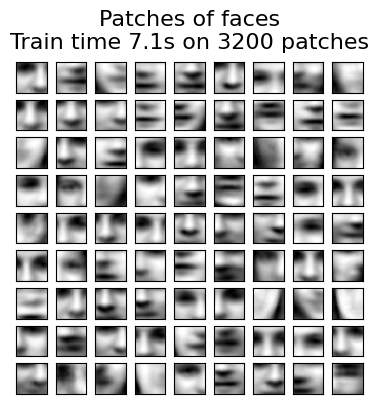

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())


plt.suptitle(
    "Patches of faces\nTrain time %.1fs on %d patches" % (dt, 8 * len(faces.images)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()